# PROJECT 1 - NUCL 610
# Diffusion Finite Difference

Import packages required for the codes

In [ ]:
import math as m
import cmath as cm
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fsolve

# Input Processing

---



In [ ]:
#NUCL 610, Project 1, Part A, Finite Difference Method for Diffusion Equation
#_____________________________________________________________________________

#Modules to import
import math
import numpy
#_____________________________________________________________________________

#INITIALIZATION

#ALL INPUTS

#Type of fuel in each region as listed in the  problem statement
def_regions = ['UO2', 'UO2', 'UO2', 'UO2', 'UO2']

#Cross sections for all fuel as given in table in problem statement
Fuel = [[8.873837e-3, 5.424022e-3, 2.332139e-1, 1.592122e-2],
	   [6.377025e-2, 9.959442e-2, 8.918111e-1, 0],
	   [1.406811e-2, 1.126274e-2, 2.219159e-1, 1.147102e-2],
	   [2.691350e-1, 4.577393e-1, 1.043375e+0, 0]]

#Albedo Boundary Conditions
R = 0.0
V = 0.5

#Defining UO2 as 0 and MOX as 2 for indexing
regions = numpy.zeros(5)
y = 0
for x in def_regions:
	if x == 'MOX':
		regions[y] = 2
	y += 1


#Initial guess for lambda
lam = 1.0
lam_prev = .1


Number_of_mesh = 3

#Number of mesh in each of five regions
Mesh_num = numpy.array([1, 1, 1, 1, 1]) * Number_of_mesh

sum_Mesh = sum(Mesh_num)


#Width of mesh in each region
width = numpy.zeros(len(Mesh_num))
y = 0
for x in Mesh_num:
	width[y] = 20. / x
	y +=1
#Width of each individual mesh
width_all = [0.0]
y = 0
for x in width:
	width_all.extend(numpy.ones(Mesh_num[y])*width[y])
	y += 1
width_all.pop(0)

#Material in each mesh
region_mesh = [0]
y = 0
for x in width:
	region_mesh.extend(numpy.ones(Mesh_num[y])*regions[y])
	y += 1
region_mesh.pop(0)
region_mesh  = list(map(int, region_mesh))


#Flux initial guess for Group 1 and 2
phi1 = numpy.ones(sum_Mesh)*1e5
phi1_prev = phi1
phi2 = numpy.ones(sum_Mesh)*1e5
phi2_prev = phi2



#Boundary Conditions
al = R
ar = V


#Coefficient matrix for Group 1
G1A = numpy.zeros((sum_Mesh,sum_Mesh))
if al == 0:
	G1A[0][0] = 0
else:
	G1A[0][0] = 1/((1/al)+(width_all[0]*3*Fuel[region_mesh[0]][2]/2))
if ar == 0:
	G1A[sum_Mesh-1][sum_Mesh-1] = 0
else:
	G1A[sum_Mesh-1][sum_Mesh-1] = 1/((1/ar)+(width_all[sum_Mesh-1]*3*Fuel[region_mesh[0]][2]/2))

D_curr = 0
for x in range(sum_Mesh):
	for y in [x-1, x, x+1]:
		if x == 0:
			if y == x-1:
				continue
		if x == sum_Mesh-1:
			if y == x+1:
				break

		if x == sum_Mesh-1 and x == y:
			G1A[x][y] += D_curr
			G1A[x][y] += width_all[x] * (Fuel[region_mesh[x]][0] + Fuel[region_mesh[x]][3])
		else:
			if y == x:
				G1A[x][y] += D_curr
				G1A[x][y] += width_all[x] * (Fuel[region_mesh[x]][0] + Fuel[region_mesh[x]][3])
				D_curr = 1/((width_all[x]*3*Fuel[region_mesh[x]][2]/ 2) + (width_all[x+1]*3*Fuel[region_mesh[x+1]][2]/ 2))
				G1A[x][y] += D_curr
			else:
				G1A[x][y] -= D_curr


#Coefficient matrix for Group 2
G2A = numpy.zeros((sum_Mesh,sum_Mesh))
if al == 0:
	G2A[0][0] = 0
else:
	G2A[0][0] = 1/((1/al)+(width_all[0]*3*Fuel[region_mesh[0]+1][2]/2))
if ar == 0:
	G2A[sum_Mesh-1][sum_Mesh-1] = 0
else:
	G2A[sum_Mesh-1][sum_Mesh-1] = 1/((1/ar)+(width_all[sum_Mesh-1]*3*Fuel[region_mesh[0]+1][2]/2))

D_curr = 0
for x in range(sum_Mesh):
	for y in [x-1, x, x+1]:
		if x == 0:
			if y == x-1:
				continue
		if x == sum_Mesh-1:
			if y == x+1:
				break

		if x == sum_Mesh-1 and x == y:
			G2A[x][y] += D_curr
			G2A[x][y] += width_all[x]*(Fuel[region_mesh[x]+1][0] + Fuel[region_mesh[x]+1][3])
		else:
			if y == x:
				G2A[x][y] += D_curr
				G2A[x][y] += width_all[x]*(Fuel[region_mesh[x]+1][0] + Fuel[region_mesh[x]+1][3])
				D_curr = 1/((width_all[x]*3*Fuel[region_mesh[x]+1][2]/ 2) + (width_all[x+1]*3*Fuel[region_mesh[x+1]+1][2]/ 2))
				G2A[x][y] += D_curr
			else:
				G2A[x][y] -= D_curr

source_group1 = numpy.zeros((sum_Mesh,1))
source_group2 = numpy.zeros((sum_Mesh,1))


lam_vec = [lam]

while abs((lam - lam_prev)/lam_prev) >= 1e-5:

	lam_prev = lam

	Sfx = 0
	Sfx_prev = 0

	for x in range(sum_Mesh):
		source_group1[x][0] = width_all[x]*lam_prev*(Fuel[region_mesh[x]][1]*phi1_prev[x] + Fuel[region_mesh[x]+1][1]*phi2_prev[x])
		source_group2[x][0] = width_all[x]*Fuel[region_mesh[x]][3]*phi1_prev[x]

	phi1 = numpy.linalg.inv(G1A).dot(source_group1)
	phi2 = numpy.linalg.inv(G2A).dot(source_group2)


	for x in range(sum_Mesh):
		Sfx_prev += width_all[x]*(Fuel[region_mesh[x]][1]*phi1_prev[x] + Fuel[region_mesh[x]+1][1]*phi2_prev[x])
		Sfx += width_all[x]*(Fuel[region_mesh[x]][1]*phi1[x] + Fuel[region_mesh[x]+1][1]*phi2[x])

	phi1_prev = phi1
	phi2_prev = phi2

	lam = lam_prev*(Sfx_prev/Sfx)

	lam_vec.append(float(lam))

	phig1_1avg = sum(phi1[slice(0,Number_of_mesh)])/Number_of_mesh
	phig1_2avg = sum(phi1[slice(Number_of_mesh,2*Number_of_mesh)])/Number_of_mesh
	phig1_3avg = sum(phi1[slice(2*Number_of_mesh,3*Number_of_mesh)])/Number_of_mesh
	phig1_4avg = sum(phi1[slice(3*Number_of_mesh,4*Number_of_mesh)])/Number_of_mesh
	phig1_5avg = sum(phi1[slice(4*Number_of_mesh,5*Number_of_mesh)])/Number_of_mesh

	phig2_1avg = sum(phi2[slice(0,Number_of_mesh)])/Number_of_mesh
	phig2_2avg = sum(phi2[slice(Number_of_mesh,2*Number_of_mesh)])/Number_of_mesh
	phig2_3avg = sum(phi2[slice(2*Number_of_mesh,3*Number_of_mesh)])/Number_of_mesh
	phig2_4avg = sum(phi2[slice(3*Number_of_mesh,4*Number_of_mesh)])/Number_of_mesh
	phig2_5avg = sum(phi2[slice(4*Number_of_mesh,5*Number_of_mesh)])/Number_of_mesh



print(1/lam)
print(len(lam_vec)-1)





[1.20377569]
73


In [ ]:
def input_contents():
  contents = '''
XSEC
UO2	1	8.873837e-3	5.424022e-3	2.332139e-1	1.592122e-2
	2	6.377025e-2	9.959442e-2	8.918111e-1	0
MOX	1	1.406811e-2	1.126274e-2	2.219159e-1	1.147102e-2 
	2	2.691350e-1	4.577393e-1	1.043375e+0	0

BC # 0 = refl, 2 = vac
0 2

GEOM
5*20
UO2 UO2 UO2 UO2 UO2
'''
  return contents

In [ ]:
def read_input(nregions, materials, nmesh_per_mat=1):
  '''
  nregions = Number of total regions in geometry
  materials = List of materials with a length of nmesh
  nmesh_per_reg = Number of refined meshes per material region
  nmesh = Number of total meshes in geometry
  lmesh = length of each nmesh region
  '''
  # set data
  geom_length = 100
  ng = 2
  XS_num = 4
  nmesh = nregions * nmesh_per_mat
  lmesh = geom_length / nmesh

  data = [[8.873837e-3,	5.424022e-3,	2.332139e-1,	1.592122e-2],
	        [6.377025e-2,	9.959442e-2,	8.918111e-1,	0],
          [1.406811e-2, 1.126274e-2,	2.219159e-1,	1.147102e-2],
          [2.691350e-1, 4.577393e-1,	1.043375e+0,	0]]

  # initialize
  geom = [lmesh]*nmesh
  xs = np.zeros([nmesh, XS_num, ng])
  mat_xs = {'UO2':{0:{}, 1:{}, 2:{}, 3:{}}, 'MOX':{0:{}, 1:{}, 2:{}, 3:{}}}
  BC = [0,2] # left, right; 0: reflective, 2: vacuum

  # redefine materials
  new_materials = []
  for mat in materials:
    for idx in range(nmesh_per_mat):
      new_materials.append(mat)
  
  # process xs
  for idx,mat in enumerate(mat_xs.keys()):
    offset = idx*ng
    for xs_type in range(XS_num):
      for g in range(ng):
        mat_xs[mat][xs_type][g] = float(data[g+offset][xs_type])
        
  # process GEOM
  for idx,mat in enumerate(new_materials):
    offset = idx*ng
    for xs_type in range(XS_num):
      for g in range(ng):
        xs[idx][xs_type][g] = mat_xs[mat][xs_type][g]
  
  return (new_materials, xs, BC, geom, nmesh, ng)

## Analytical Diffusion Solver (Anna, True, Tao)

---



In [ ]:
# analytical solution

def _analytical(case, lam_init):

    def _init_global():
        if case == 'UO2':
            para_dict = {
                "sig_a1": 8.873837e-3,
                "nusig_f1": 5.424022e-3,
                "sig_tr1": 2.332139e-1,
                "sig_12": 1.592122e-2,
                "sig_a2": 6.377025e-2,
                "nusig_f2": 9.959442e-2,
                "sig_tr2": 8.918111e-1,
                "sig_21": 0,
                "h": 100
            }
        elif case == 'MOX':
            para_dict = {
                "sig_a1": 1.406811e-2,
                "nusig_f1": 1.126274e-2,
                "sig_tr1": 2.219159e-1,
                "sig_12": 1.147102e-2,
                "sig_a2": 2.691350e-1,
                "nusig_f2": 4.577393e-1,
                "sig_tr2": 1.043375e+0,
                "sig_21": 0,
                "h": 100
            }
        return para_dict;

        
    #Ref: slides #4 page 3
    def _cn(Bsquare, h):
        if Bsquare > 0:
            return m.cos(m.sqrt(Bsquare) * h)
        elif Bsquare == 0:
            return 1;
        else:
            return m.cosh(abs(cm.sqrt(Bsquare)) * h)
    
    def _sn(Bsquare, h):
        if Bsquare > 0:
            return m.sin(m.sqrt(Bsquare) * h) / m.sqrt(Bsquare)
        elif Bsquare == 0:
            return h;
        else:
            return m.sinh(abs(cm.sqrt(Bsquare)) * h) / abs(cm.sqrt(Bsquare))
    
    #Ref: slides #4 page 7 
    def _B1square(p, q):
        return (-p + m.sqrt(p**2 + 4 * q)) / 2
    
    def _B2square(p, q):
        return (-p - m.sqrt(p**2 + 4 * q)) / 2
    
    def _f(lam):
        #initalize input variables
        parameter = _init_global()
        sig_a1 = parameter["sig_a1"]
        nusig_f1 = parameter["nusig_f1"]
        sig_tr1 = parameter["sig_tr1"]
        sig_12 = parameter["sig_12"]
        sig_a2 = parameter["sig_a2"]
        nusig_f2 = parameter["nusig_f2"]
        sig_tr2 = parameter["sig_tr2"]
        sig_21 = parameter["sig_21"]
        h  = parameter["h"]
        
        #find D1, D2, sig_r1, sig_r2
        D1 = 1.0 / 3 / sig_tr1;
        D2 = 1.0 / 3 / sig_tr2;
        sig_r1 = sig_a1 + sig_12;
        sig_r2 = sig_a2 + sig_21;
        
        #computation
        p = sig_r2 / D2 + (sig_r1 - lam * nusig_f1) / D1
        q = (lam * nusig_f2 + sig_21) * sig_12 - sig_r2 * (sig_r1 - lam * nusig_f1)
        q = q / D1 / D2
        
        B1s = _B1square(p, q)
        B2s = _B2square(p, q)
        
        sn1 = _sn(B1s, h)
        cn1 = _cn(B1s, h)
        sn2 = _sn(B2s, h)
        cn2 = _cn(B2s, h)
        
        left = (D2 * B1s + sig_r2) * (2 * sn1 * D1 * B1s - cn1) * (-2 * sn2 * D2 * B2s + cn2)
        right = (D2 * B2s + sig_r2) * (-2 * sn2 * D1 * B2s + cn2) * (2 * sn1 * D2 * B1s - cn1)
        
        return left - right
 
    #plotting phi_1(x) and phi_2(x)
    def _phi(lam, lam_init):
        #initalize input variables
        parameter = _init_global()
        sig_a1 = parameter["sig_a1"]
        nusig_f1 = parameter["nusig_f1"]
        sig_tr1 = parameter["sig_tr1"]
        sig_12 = parameter["sig_12"]
        sig_a2 = parameter["sig_a2"]
        nusig_f2 = parameter["nusig_f2"]
        sig_tr2 = parameter["sig_tr2"]
        sig_21 = parameter["sig_21"]
        h  = parameter["h"]
        
        #find D1, D2, sig_r1, sig_r2
        D1 = 1.0 / 3 / sig_tr1;
        D2 = 1.0 / 3 / sig_tr2;
        sig_r1 = sig_a1 + sig_12;
        sig_r2 = sig_a2 + sig_21;
        
        #computation
        p = sig_r2 / D2 + (sig_r1 - lam * nusig_f1) / D1
        q = (lam * nusig_f2 + sig_21) * sig_12 - sig_r2 * (sig_r1 - lam * nusig_f1)
        q = q / D1 / D2
        
        B1s = _B1square(p, q)
        B2s = _B2square(p, q)
        
        sn1 = _sn(B1s, h)
        cn1 = _cn(B1s, h)
        sn2 = _sn(B2s, h)
        cn2 = _cn(B2s, h)
        
        C10 = -2 * sn2 * D2 * B2s + cn2
        C20 = 2 * sn1 * D2 * B1s - cn1
        
        C20 = C20/C10;
        C10 = 1;
        # print("C10 = " + str(C10) + ";  C20 = " + str(C20))
        
        num = h*50+1 #6
        X = np.linspace(0, h, num)
        phi = np.zeros([num,2])
        # phi1 = np.zeros(num)
        # phi2 = np.zeros(num)
        
        file1 = open("%s.txt" %(case+"_phi_result"),"w")
        scale = (D2 * B1s + sig_r2) * C10 * _cn(B1s, X[0]) + \
                (D2 * B2s + sig_r2) * C20 * _cn(B2s, X[0])
        for i in range(len(X)):
            a1 = (D2 * B1s + sig_r2) * C10 * _cn(B1s, X[i])
            a2 = (D2 * B2s + sig_r2) * C20 * _cn(B2s, X[i])
            phi[i,0] = a1 + a2
            
            b1 = sig_12 * C10 * _cn(B1s, X[i])
            b2 = sig_12 * C20 * _cn(B2s, X[i])
            phi[i,1] = b1 + b2
            
            phi[i,0] = phi[i,0] / scale
            phi[i,1] = phi[i,1] / scale
            file1.write(str(X[i]) + "  " + str(phi[i,0])  + "  " + str(phi[i,1]))
            file1.write("\n")
        
        file1.close()
        #plt.plot(X, phi[:,0], label = "$\phi_1(x)$")
        #plt.plot(X, phi[:,1], label = "$\phi_2(x)$")
        #plt.yscale("log")
        #plt.xlabel('x/cm')
        #plt.ylabel('$\phi(x)$')
        #plt.legend()
        #plt.show()
        return (X, phi, C10, C20)
    
    lamguess = lam_init
    lam = fsolve(_f, lamguess)
    #s = "Estimated lambda for " + case + ": " + str(lam);
    s = "Estimated k-eff for " + case + ": " + str(1/lam);
    #print(s)
    X, phi, C10, C20 = _phi(lam, lam_init)

    return (X, phi, 1/lam[0], C10, C20[0])

In [ ]:
_analytical("UO2", 0.8)

(array([0.000e+00, 2.000e-02, 4.000e-02, ..., 9.996e+01, 9.998e+01,
        1.000e+02]), array([[1.        , 0.24932275],
        [0.99999995, 0.24932274],
        [0.99999981, 0.24932271],
        ...,
        [0.04209261, 0.00480985],
        [0.04180198, 0.00468827],
        [0.04151149, 0.0045663 ]]), 1.203941028854214, 1, -8.89927622060852e-21)

In [ ]:
_analytical("MOX", 0.8)

(array([0.000e+00, 2.000e-02, 4.000e-02, ..., 9.996e+01, 9.998e+01,
        1.000e+02]), array([[1.00000000e+00, 4.26100275e-02],
        [9.99999953e-01, 4.26100255e-02],
        [9.99999814e-01, 4.26100196e-02],
        ...,
        [4.56070147e-02, 1.02829502e-03],
        [4.53072402e-02, 9.98459099e-04],
        [4.50075572e-02, 9.68308900e-04]]), 1.1884234505396496, 1, -3.346173574765234e-42)

## PART A - Finite Difference Code (Oscar, Rizki, Stepan)



---



In [ ]:
def fd_diffusion(materials, xs, BC, geom, ng, lam_init=1, show_iter=True):
  # Assign enum to XS names
  ab   = 0
  nf   = 1
  tr   = 2
  scat = 3
  num  = 4
  
  nmesh = len(geom)

  # Initialize fluxes and lambda
  phi = np.ones([nmesh,ng])
  sf  = np.ones([nmesh])
  ss  = np.ones([nmesh])
  lamb = 1.0
  lamb_prev = 0.1

  # Initialize sources
  sf_prev = sf.copy()
  sf = np.zeros([nmesh])
  ss = np.zeros([nmesh])
  for idx in range(nmesh):
    for g in range(ng):
      sf[idx] = sf[idx] + phi[idx][g]*xs[idx][nf][g]   # fission source
      ss[idx] = ss[idx] + phi[idx][g]*xs[idx][scat][g] # scattering source

  # Initialize error and tolerance
  tol1 = 1E-5
  tol2 = 1E-5
  error1 = np.abs(lamb-lamb_prev)/lamb_prev
  error2 = 0.0
  for idx in range(nmesh):
    sf_change = np.abs(sf[idx] - sf_prev[idx])/sf_prev[idx]
    error2 = max(sf_change,error2)

  # Diffusion Coefficients
  Dc = np.ones([nmesh+1,ng])
  for idx in range(nmesh):  
    Dc[idx] = 1/3*np.reciprocal(xs[idx][tr])

  Dtilda = np.zeros([nmesh+1,ng])
  for idx in range(nmesh+1):
    for g in range(ng):
      # left BC
      if idx==0:
        Dtilda[idx][g] = 0.0
      
      # right BC
      elif idx==nmesh: 
        Dtilda[idx][g] = 1/(1/0.5 + geom[nmesh-1]/2/Dc[nmesh-1][g])

      # interior
      else: 
        Dtilda[idx][g] = 1/(geom[idx-1]/2/Dc[idx-1][g] + geom[idx]/2/Dc[idx][g])
  
  # Form finite difference matrix and initial source terms
  A1 = np.zeros([nmesh,nmesh])
  A2 = np.zeros([nmesh,nmesh])
  b1 = np.zeros([nmesh])
  b2 = np.zeros([nmesh])

  # Fill the matrix
  for idx in range(nmesh):
    xst1 = xs[idx][ab][0]+xs[idx][scat][0]
    A1[idx][idx]   = geom[idx]*xst1 + Dtilda[idx][0] + Dtilda[idx+1][0]
    A2[idx][idx]   = geom[idx]*xs[idx][ab][1] + Dtilda[idx][1] + Dtilda[idx+1][1]
    b1[idx]        = geom[idx]*lamb*sf[idx]
    b2[idx]        = geom[idx]*ss[idx]

    # left BC  
    if idx==0: 
      A1[idx][idx+1] = -Dtilda[idx+1][0]
      A2[idx][idx+1] = -Dtilda[idx+1][1]
    
    # right BC
    elif idx==nmesh-1:
      A1[idx][idx-1] = -Dtilda[idx][0]
      A2[idx][idx-1] = -Dtilda[idx][1]
    
    # interior
    else:
      A1[idx][idx-1] = -Dtilda[idx][0]
      A2[idx][idx-1] = -Dtilda[idx][1]
      A1[idx][idx+1] = -Dtilda[idx+1][0]
      A2[idx][idx+1] = -Dtilda[idx+1][1]  

  # Start outer iteration
  iter_max = 500
  iter = 1
  while (error1>tol1 or error2>tol2):
    if iter >= iter_max:
      print("WARNING: Iteration finished without convergence")
      break

    # Solve finite difference equations
    phi[:,0] = np.linalg.solve(A1, b1)
    phi[:,1] = np.linalg.solve(A2, b2)
    
    # Update Fission and Scattering sources
    sf_prev = sf.copy()
    sf = np.zeros([nmesh])
    ss = np.zeros([nmesh])
    for idx in range(nmesh):
      for g in range(ng):
        sf[idx] = sf[idx] + phi[idx][g]*xs[idx][nf][g]   # fission source
        ss[idx] = ss[idx] + phi[idx][g]*xs[idx][scat][g] # scattering source
    
    # Determine new lambda
    lamb_prev = lamb
    lamb = lamb_prev*sum(sf_prev)/sum(sf)
    # Determine keff from lambda
    keff = 1/lamb 

    # Update Source Constants, b
    for idx in range(nmesh):
      b1[idx] = geom[idx]*lamb*sf[idx]
      b2[idx] = geom[idx]*ss[idx] 

    # Update error
    error1 = np.abs(lamb-lamb_prev)/lamb_prev
    error2 = 0.0
    for idx in range(nmesh):
      sf_change = np.abs(sf[idx]-sf_prev[idx])/sf_prev[idx]
      error2 = max(sf_change,error2) 
    
    if show_iter:
      print(f"iter {iter:03d}:  keff:{keff:.5f}   lambda_err: {error1:.5f}   fission_err: {error2:.5f}")
    iter += 1

  # Normalize flux
  scale = max(phi[0,:])
  phi[:,0] = phi[:,0]/scale
  phi[:,1] = phi[:,1]/scale

  return(phi,keff)



**Flux Plotting**

In [ ]:
def plot_flux(phi, nmesh, length, plot_type, log=False, C=0):
  ng = 2

  if plot_type == 'FD':
    nodes = [float((i+1/2)*length) for i in range(nmesh)]
  else:
    num = len(phi)
    nodes = np.linspace(0, 100, num)


  colors = ('blue', 'red')
  for g in range(ng):
    if plot_type == 'FD':
      plt.plot(nodes,phi[:,g],label=f'Group {g+1}', color=colors[g])
    else:
      plt.plot(nodes,phi[:,g],label=f'Group {g+1}')
  
  #plt.xticks([float(i*length) for i in range(nmesh+1)])
  plt.xlabel("x (cm)")
  plt.ylabel(r'$\phi$')
  if log:
    plt.yscale("log")
  if plot_type == 'FD':
    plt.title(f"Finite Difference Flux with {nmesh} meshes of length {length*10} mm")

  else:
    plt.title(f"Analytical Flux (Refl/Vac) (C10 = 1, C20 = {C:.06e}")
  
  plt.legend()


# This is all stuff for adding the geometry to part C
# TO DO: put the following commented out lines in a conditional 
#  regions = range(20,101,20)
#  plt.vlines(regions, 0, 1, lw=1, color='grey')
#  i=1
#  for values in range(0,100,20):
#    if i == -1:
#      regioncolor = 'lemonchiffon'
#    else:
#      regioncolor = 'peachpuff'
#    plt.fill_between((values, values+20),0,1, color = regioncolor)
#    i *= -1
#  plt.text(6.5,0.45, 'UO2', color='chocolate')
#  plt.text(26.5,0.45, 'MOX', color='darkgoldenrod')
#  plt.text(101,0.45, 'Void', rotation=90 )
#  plt.text(-3.5,0.25, 'Reflective boundary', rotation=90) 
#  plt.vlines(0,0,1, linestyles='dashed', lw=1)

  plt.show()

  return

In [ ]:
def plot_flux_diff(phi_FD, nmesh, length, phi_A, log=False):
  nodes_FD = [float((i+1/2)*length) for i in range(nmesh)]
  nodes_A  = np.linspace(0, 100, len(phi_A))

  colors = ('blue', 'red')
  for g in range(ng):
    plt.plot(nodes_FD,phi_FD[:,g])
    plt.plot(nodes_A,phi_A[:,g],label=f'Group {g+1}', color=colors[g])

 # plt.xticks([float(i*length) for i in range(nmesh+1)])
  plt.xlabel("x (cm)")
  plt.ylabel(r'$\phi$')
  if log:
    plt.yscale("log")
  plt.title(f"Difference between Relative and Analytical Flux (Refl/Vac)")
  plt.legend()
  plt.show()

  return

### Finite Difference Code Testing (A / B)


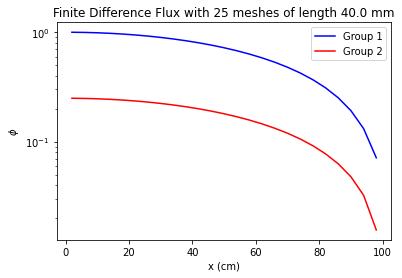

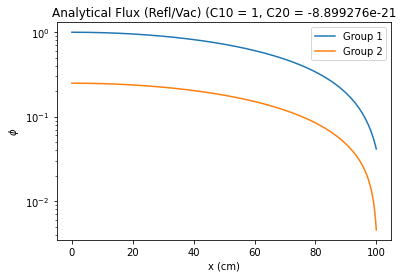

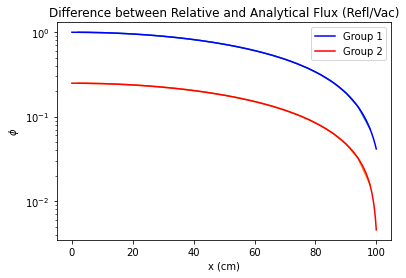

Finite Diff k-eff for UO2: 1.20395023
Analytical  k-eff for UO2: 1.20394103 (C10 = 1, C20 = -8.89927622060852e-21)
Error (pcm): 0.763959
[0.0006141  0.00061118]
[0.00063871 0.00063774]
[0.00072571 0.00072795]
[0.00088735 0.000892  ]
[0.00117922 0.00380709]


In [ ]:
# Set input
nregions = 5
nmesh_per_region = 5
mats  = ['UO2']*nregions
lam_init = 0.8
log_plot = True

# Assign data
materials, xs, BC, geom, nmesh, ng = read_input(nregions, mats, nmesh_per_region)

# Run the finite difference calculation
show_iter = False
phi, keff = fd_diffusion(materials, xs, BC, geom, ng, lam_init, show_iter)

# Run the analytical calculation
X_a, phi_a, keff_a, C10, C20 = _analytical(materials[0], lam_init)

# Plot FD flux
plot_flux(phi, nmesh, geom[0], 'FD', log_plot)

# Plot Analytical flux
plot_flux(phi_a, nmesh, geom[0], 'A', log_plot, C20)

# Plot Flux differences
plot_flux_diff(phi, nmesh, geom[0], phi_a, log_plot)

# Print k-eff error
line  = f"Finite Diff k-eff for {materials[0]}: {keff:.08f}\n"
line += f"Analytical  k-eff for {materials[0]}: {keff_a:.08f} " \
        f"(C10 = {C10}, C20 = {C20})\n"
line += f"Error (pcm): {1e5*(keff-keff_a)/keff_a:.06f}"
print(line)

# Difference between FD Flux and Analytical Flux
phi_1avgFD = sum(phi[slice(0,nmesh_per_region)])/nmesh_per_region
phi_2avgFD = sum(phi[slice(nmesh_per_region,2*nmesh_per_region)])/nmesh_per_region
phi_3avgFD = sum(phi[slice(2*nmesh_per_region,3*nmesh_per_region)])/nmesh_per_region
phi_4avgFD = sum(phi[slice(3*nmesh_per_region,4*nmesh_per_region)])/nmesh_per_region
phi_5avgFD = sum(phi[slice(4*nmesh_per_region,5*nmesh_per_region)])/nmesh_per_region

lenA = int((len(phi_a)-1)/5)
phi_1avgA = sum(phi_a[slice(0,lenA)])/lenA
phi_2avgA = sum(phi_a[slice(lenA,2*lenA)])/lenA
phi_3avgA = sum(phi_a[slice(2*lenA,3*lenA)])/lenA
phi_4avgA = sum(phi_a[slice(3*lenA,4*lenA)])/lenA
phi_5avgA = sum(phi_a[slice(4*lenA,5*lenA)])/lenA

print(abs(phi_1avgA - phi_1avgFD)/phi_1avgA)
print(abs(phi_2avgA - phi_2avgFD)/phi_2avgA)
print(abs(phi_3avgA - phi_3avgFD)/phi_3avgA)
print(abs(phi_4avgA - phi_4avgFD)/phi_4avgA)
print(abs(phi_5avgA - phi_5avgFD)/phi_5avgA)



## PART B - Homogeneous Model

---



In [ ]:
# write python script for part B here

## PART C - Heterogeneous Model

---



Iter 0 with 1 meshes/region: K-eff pcm diff of -0.010000000000000009
1.1983593876246195
[0.         0.75311897]
[0.06801125 0.95918936]
[0.28499713 0.82536318]
[0.50789311 0.97845682]
[0.80889997 0.95387808]


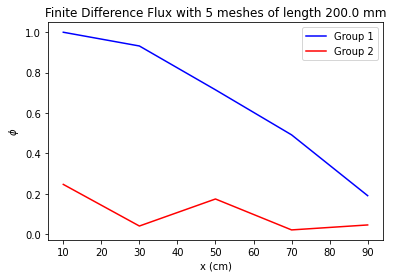

Iter 1 with 2 meshes/region: K-eff pcm diff of 0.19835938762461947
1.198890945449935
[0.01379802 0.0234464 ]
[0.00210822 0.00553623]
[0.00980727 0.03010874]
[0.00049378 0.02604283]
[0.00852012 0.03030414]


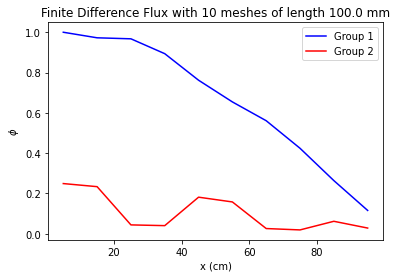

Iter 2 with 4 meshes/region: K-eff pcm diff of 0.000531557825315554
1.1999086255139848
[0.00160961 0.01679624]
[0.00296036 0.00998472]
[0.00378926 0.02819479]
[0.00478211 0.04315875]
[0.00423001 0.02775116]


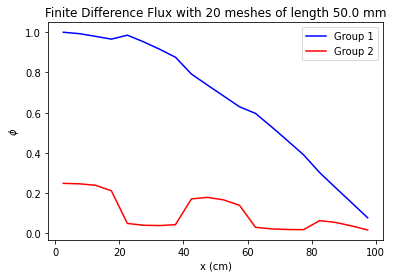

Iter 3 with 8 meshes/region: K-eff pcm diff of 0.0010176800640497863
1.200999592696746
[0.00132146 0.01477913]
[0.00421179 0.01096324]
[0.00682735 0.02740653]
[0.00580918 0.04422359]
[0.00731383 0.02499097]


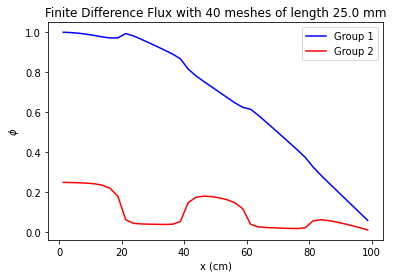

Iter 4 with 16 meshes/region: K-eff pcm diff of 0.0010909671827612488
1.20165004460905
[0.00110491 0.00860595]
[0.00267609 0.0067516 ]
[0.00435869 0.01651438]
[0.00361915 0.02548288]
[0.0047513  0.01417171]


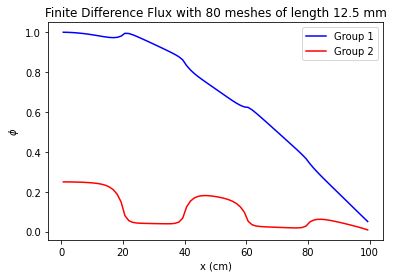

Iter 5 with 32 meshes/region: K-eff pcm diff of 0.0006504519123038399
1.2018877490088642
[0.00042924 0.0031482 ]
[0.00099506 0.00251504]
[0.00161055 0.00613059]
[0.00133713 0.00912152]
[0.00176775 0.00512034]


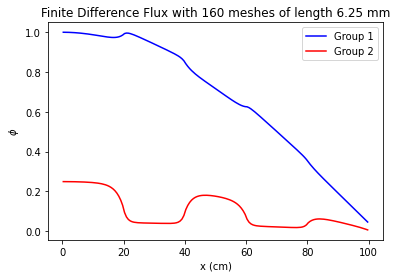

Iter 6 with 64 meshes/region: K-eff pcm diff of 0.00023770439981429803
1.2019549344564073
[0.00012311 0.00089123]
[0.00028279 0.00071599]
[0.0004565  0.00174385]
[0.00037951 0.00255947]
[0.00050234 0.00144346]


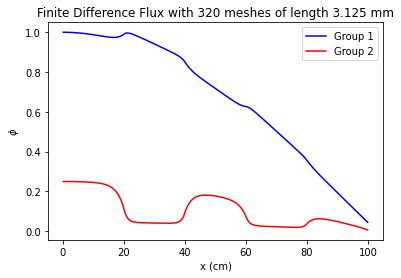

Iter 7 with 128 meshes/region: K-eff pcm diff of 6.718544754313882e-05
1.20197230183734
[3.19404128e-05 2.30502975e-04]
[7.32046559e-05 1.85461431e-04]
[0.00011808 0.00045162]
[9.82102248e-05 6.60265727e-04]
[0.00013003 0.00037291]


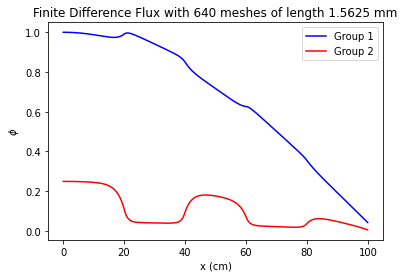

Iter 8 with 256 meshes/region: K-eff pcm diff of 1.7367380932720167e-05
1.2019766809994228
[8.06103772e-06 5.81291711e-05]
[1.84651652e-05 4.67885375e-05]
[2.97795002e-05 1.13929782e-04]
[2.47704818e-05 1.66396945e-04]
[3.27982806e-05 9.40156649e-05]


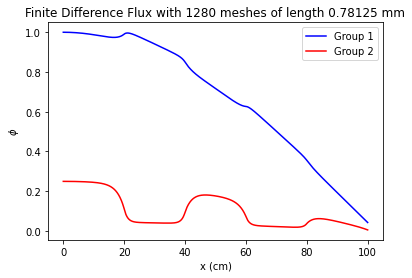

In [ ]:
# Set input
nregions = 5
nmesh_per_region = 1
mats  = ['UO2', 'MOX', 'UO2', 'MOX','UO2']
k_init = 1.01
log_plot = False

phi_1avgPrev = [1.0, 1.0]
phi_2avgPrev = [1.0, 1.0]
phi_3avgPrev = [1.0, 1.0]
phi_4avgPrev = [1.0, 1.0]
phi_5avgPrev = [1.0, 1.0]

# Run the finite difference calculation iteratively
iter = 0
k_eff = 1
k_prev = k_init
diff = k_eff - k_prev

while (abs(k_eff - k_prev) > 1e-5):
  # Save
  k_prev = k_eff

  # Solve
  materials, xs, BC, geom, nmesh, ng = read_input(nregions, mats, nmesh_per_region)
  phi, k_eff = fd_diffusion(materials, xs, BC, geom, ng, lam_init, False)

  # Difference between FD Flux and Analytical Flux
  phi_1avgFD = sum(phi[slice(0,nmesh_per_region)])/nmesh_per_region
  phi_2avgFD = sum(phi[slice(nmesh_per_region,2*nmesh_per_region)])/nmesh_per_region
  phi_3avgFD = sum(phi[slice(2*nmesh_per_region,3*nmesh_per_region)])/nmesh_per_region
  phi_4avgFD = sum(phi[slice(3*nmesh_per_region,4*nmesh_per_region)])/nmesh_per_region
  phi_5avgFD = sum(phi[slice(4*nmesh_per_region,5*nmesh_per_region)])/nmesh_per_region

  phi1_perc = abs(phi_1avgFD - phi_1avgPrev)/phi_1avgPrev
  phi2_perc = abs(phi_2avgFD - phi_2avgPrev)/phi_3avgPrev
  phi3_perc = abs(phi_3avgFD - phi_3avgPrev)/phi_3avgPrev
  phi4_perc = abs(phi_4avgFD - phi_4avgPrev)/phi_4avgPrev
  phi5_perc = abs(phi_5avgFD - phi_5avgPrev)/phi_5avgPrev



  # Show progress
  print(f"Iter {iter} with {nmesh_per_region} meshes/region: K-eff pcm diff of {diff}")
  print(k_eff)
  print(phi1_perc)
  print(phi2_perc)
  print(phi3_perc)
  print(phi4_perc)
  print(phi5_perc)

  # Update
  iter += 1
  nmesh_per_region *= 2
  diff = k_eff - k_prev
  phi_1avgPrev = phi_1avgFD
  phi_2avgPrev = phi_2avgFD
  phi_3avgPrev = phi_3avgFD
  phi_4avgPrev = phi_4avgFD
  phi_5avgPrev = phi_5avgFD
  
  # Plot FD flux
  plot_flux(phi, nmesh, geom[0], 'FD', log_plot)

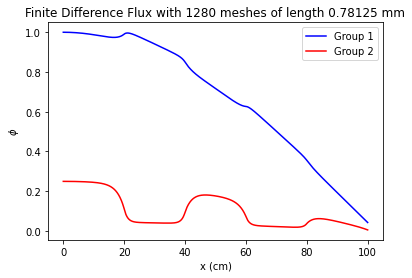

In [ ]:
# Plot FD flux
plot_flux(phi, nmesh, geom[0], 'FD', log_plot)